# build model prediction and compare each features set

In [3]:
import pandas as pd
import xgboost as xgb
import pickle
import numpy as np
import os

from gensim.models import Doc2Vec, doc2vec

In [4]:
# read preprocess article df
df = pd.read_csv('Data/article_preprocessed.csv')

In [5]:
# drop data
diff_threshold = 20
df = df[abs(df['push']-df['boo']) > diff_threshold].copy()

In [6]:
# define y
df['type'] = np.clip(df['push']-df['boo'], 0, 1)
df = df.reset_index(drop=True)

In [7]:
df['type'].value_counts()

1    17318
0     1134
Name: type, dtype: int64

In [8]:
# create a numpy format data
basic_data = np.zeros((df.shape[0], 258))

In [9]:
basic_data[:, 0] = df['idx']
basic_data[:, 1] = df['type']

## bag of words

In [10]:
# load bag of words result
with open('Data/article_count', 'rb') as file:
    _, count = pickle.load(file)

In [11]:
# select top 256 words (counts of document) 
most_count_id = np.array((count > 0).sum(axis=0))[0].argsort()[::-1][:256]

In [12]:
# subset data
count = count[:, most_count_id]

In [13]:
count_data = basic_data.copy()

In [21]:
# subset bag of words matrix
count_data[:, 2:] = count[count_data[:, 0]].toarray()

## TF-IDF

In [22]:
# load tf-idf result
with open('Data/article_tfidf', 'rb') as file:
    _, tfidf = pickle.load(file)

In [23]:
# select top 256 words (counts of document) 
most_tfidf_id = np.array((tfidf > 0).sum(axis=0))[0].argsort()[::-1][:256]

In [24]:
# subset data
tfidf = tfidf[:, most_tfidf_id]

In [25]:
tfidf_data = basic_data.copy()

In [26]:
# subset tf-idf matrix
tfidf_data[:, 2:] = tfidf[tfidf_data[:, 0]].toarray()

## average word2vec

In [27]:
# load average word2vec result
with open('Data/avg_article_vector', 'rb') as file:
    avg_vector = pickle.load(file)

In [28]:
avg_data = basic_data.copy()

In [29]:
# select rows of average word2vec
for i, row in df.iterrows():
    avg_data[i, 2:] = avg_vector[row['idx']]

## doc2vec

In [30]:
# load doc2vec model
model = Doc2Vec.load('word2vec_model/doc2vec')

In [31]:
doc2vec_data = basic_data.copy()

In [32]:
# select idx of doc2vec
for i, row in df.iterrows():
    doc2vec_data[i, 2:] = model.docvecs[str(row['idx'])]

# prediction model

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
# split data to training and testing data
train, test = train_test_split(df, test_size=0.2, stratify=df['type'])
train_idx = np.array(train.index)
test_idx = np.array(test.index)

In [47]:
# define a dictionary to collect model result
result = {}

## train model use xgboost

In [48]:
# bag of words
model = xgb.XGBClassifier()
model.fit(count_data[train_idx, 2:], count_data[train_idx, 1], 
          eval_set=[(count_data[test_idx, 2:], count_data[test_idx, 1])], eval_metric='auc'
         )

# testing auc
result['bag_of_words'] = model.evals_result()['validation_0']['auc'][-1]

[0]	validation_0-auc:0.547592
[1]	validation_0-auc:0.553713
[2]	validation_0-auc:0.57016
[3]	validation_0-auc:0.574974
[4]	validation_0-auc:0.579326
[5]	validation_0-auc:0.579448
[6]	validation_0-auc:0.579552
[7]	validation_0-auc:0.589814
[8]	validation_0-auc:0.589979
[9]	validation_0-auc:0.589978
[10]	validation_0-auc:0.589934
[11]	validation_0-auc:0.589983
[12]	validation_0-auc:0.602551
[13]	validation_0-auc:0.60241
[14]	validation_0-auc:0.602525
[15]	validation_0-auc:0.602591
[16]	validation_0-auc:0.626555
[17]	validation_0-auc:0.626641
[18]	validation_0-auc:0.628976
[19]	validation_0-auc:0.646033
[20]	validation_0-auc:0.640935
[21]	validation_0-auc:0.641034
[22]	validation_0-auc:0.647721
[23]	validation_0-auc:0.659341
[24]	validation_0-auc:0.659271
[25]	validation_0-auc:0.658962
[26]	validation_0-auc:0.662527
[27]	validation_0-auc:0.668517
[28]	validation_0-auc:0.682214
[29]	validation_0-auc:0.681801
[30]	validation_0-auc:0.681543
[31]	validation_0-auc:0.681024
[32]	validation_0-au

In [49]:
# tf-idf
model = xgb.XGBClassifier()
model.fit(tfidf_data[train_idx, 2:], tfidf_data[train_idx, 1], 
          eval_set=[(tfidf_data[test_idx, 2:], tfidf_data[test_idx, 1])], eval_metric='auc'
         )

# testing auc
result['tf-idf'] = model.evals_result()['validation_0']['auc'][-1]

[0]	validation_0-auc:0.547592
[1]	validation_0-auc:0.553713
[2]	validation_0-auc:0.57016
[3]	validation_0-auc:0.574974
[4]	validation_0-auc:0.579326
[5]	validation_0-auc:0.579448
[6]	validation_0-auc:0.579552
[7]	validation_0-auc:0.589814
[8]	validation_0-auc:0.589979
[9]	validation_0-auc:0.589978
[10]	validation_0-auc:0.589934
[11]	validation_0-auc:0.589983
[12]	validation_0-auc:0.602551
[13]	validation_0-auc:0.60241
[14]	validation_0-auc:0.602525
[15]	validation_0-auc:0.602591
[16]	validation_0-auc:0.626555
[17]	validation_0-auc:0.626641
[18]	validation_0-auc:0.628976
[19]	validation_0-auc:0.646033
[20]	validation_0-auc:0.640935
[21]	validation_0-auc:0.641034
[22]	validation_0-auc:0.647721
[23]	validation_0-auc:0.659341
[24]	validation_0-auc:0.659271
[25]	validation_0-auc:0.658962
[26]	validation_0-auc:0.662527
[27]	validation_0-auc:0.668517
[28]	validation_0-auc:0.682214
[29]	validation_0-auc:0.681801
[30]	validation_0-auc:0.681543
[31]	validation_0-auc:0.681024
[32]	validation_0-au

In [50]:
# average word2vec
model = xgb.XGBClassifier()
model.fit(avg_data[train_idx, 2:], avg_data[train_idx, 1], 
          eval_set=[(avg_data[test_idx, 2:], avg_data[test_idx, 1])], eval_metric='auc'
         )

# testing auc
result['avg_word2vec'] = model.evals_result()['validation_0']['auc'][-1]

[0]	validation_0-auc:0.649113
[1]	validation_0-auc:0.726836
[2]	validation_0-auc:0.714625
[3]	validation_0-auc:0.723442
[4]	validation_0-auc:0.735306
[5]	validation_0-auc:0.738055
[6]	validation_0-auc:0.751799
[7]	validation_0-auc:0.753846
[8]	validation_0-auc:0.764811
[9]	validation_0-auc:0.764999
[10]	validation_0-auc:0.773846
[11]	validation_0-auc:0.774445
[12]	validation_0-auc:0.780314
[13]	validation_0-auc:0.776284
[14]	validation_0-auc:0.779748
[15]	validation_0-auc:0.782091
[16]	validation_0-auc:0.784644
[17]	validation_0-auc:0.789759
[18]	validation_0-auc:0.79107
[19]	validation_0-auc:0.791459
[20]	validation_0-auc:0.792068
[21]	validation_0-auc:0.794516
[22]	validation_0-auc:0.798084
[23]	validation_0-auc:0.799264
[24]	validation_0-auc:0.800731
[25]	validation_0-auc:0.799307
[26]	validation_0-auc:0.804461
[27]	validation_0-auc:0.804739
[28]	validation_0-auc:0.807147
[29]	validation_0-auc:0.806204
[30]	validation_0-auc:0.81026
[31]	validation_0-auc:0.809062
[32]	validation_0-au

In [51]:
# doc2vec
model = xgb.XGBClassifier()
model.fit(doc2vec_data[train_idx, 2:], doc2vec_data[train_idx, 1],
          eval_set=[(doc2vec_data[test_idx, 2:], doc2vec_data[test_idx, 1])], eval_metric='auc'
         )

# testing auc
result['doc2vec'] = model.evals_result()['validation_0']['auc'][-1]

[0]	validation_0-auc:0.622283
[1]	validation_0-auc:0.641037
[2]	validation_0-auc:0.664336
[3]	validation_0-auc:0.681412
[4]	validation_0-auc:0.67625
[5]	validation_0-auc:0.687145
[6]	validation_0-auc:0.686344
[7]	validation_0-auc:0.691653
[8]	validation_0-auc:0.688248
[9]	validation_0-auc:0.692329
[10]	validation_0-auc:0.695032
[11]	validation_0-auc:0.696109
[12]	validation_0-auc:0.696987
[13]	validation_0-auc:0.702816
[14]	validation_0-auc:0.700369
[15]	validation_0-auc:0.70391
[16]	validation_0-auc:0.701605
[17]	validation_0-auc:0.704016
[18]	validation_0-auc:0.704488
[19]	validation_0-auc:0.703941
[20]	validation_0-auc:0.701632
[21]	validation_0-auc:0.709994
[22]	validation_0-auc:0.712355
[23]	validation_0-auc:0.721086
[24]	validation_0-auc:0.72171
[25]	validation_0-auc:0.724511
[26]	validation_0-auc:0.731958
[27]	validation_0-auc:0.736956
[28]	validation_0-auc:0.742109
[29]	validation_0-auc:0.745728
[30]	validation_0-auc:0.747806
[31]	validation_0-auc:0.749933
[32]	validation_0-auc

## plot result

In [52]:
import matplotlib.pyplot as plt

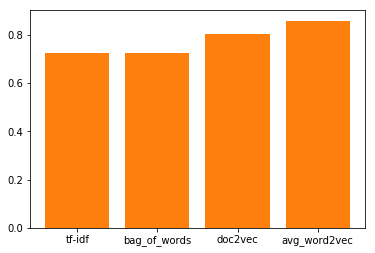

In [53]:
plt.bar(np.arange(4), result.values())
plt.xticks(np.arange(4), result.keys())
plt.show()